# fdfdpy test notebook

## Import/setup

In [15]:
from fdfdpy import Simulation

import matplotlib.pylab as plt
import numpy as np
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.style.use(['https://git.io/photons.mplstyle',
               'https://git.io/photons-paper.mplstyle'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
omega = 2*np.pi*200e12
dl = 0.01
eps_r = np.ones((600, 200))
eps_r[:,80:120] = 12.25

nl_region = np.zeros(eps_r.shape)
nl_region[100:500, 80:120] = 1

simulation = Simulation(omega, eps_r, dl, [15, 15], 'Ez')
simulation.add_mode(3.5, 'x', [17, 100], 150)
simulation.setup_modes()
simulation.solve_fields()

fld0 = simulation.fields['Ez'][20, 100]
fld1 = simulation.fields['Ez'][580, 100]
T_linear = fld1/fld0

chi3 = 2.8*1e-18/simulation.L0**2
kerr_nonlinearity = lambda e: 3*chi3*np.square(np.abs(e))
dkerr_de = lambda e: 3*chi3*np.conj(e)

srcval_vec = np.logspace(1, 3, 10)
# srcval_vec = np.insert(srcval_vec,0,1e-3)
pwr_vec = np.array([])
T_vec = np.array([])
for srcval in srcval_vec:
    print(srcval)
    simulation.setup_modes()
    simulation.src *= srcval
    simulation.solve_fields_nl(kerr_nonlinearity, nl_region,
                               dnl_de=dkerr_de, timing=False, averaging=True,
                               Estart=None, solver_nl='newton')
    fld0 = simulation.fields['Ez'][20, 100]
    fld1 = simulation.fields['Ez'][580, 100]
    T_vec = np.append(T_vec, fld1/fld0)
    pwr = simulation.flux_probe('x', [580, 100], 150)
    pwr_vec = np.append(pwr_vec, pwr)

10.0
16.68100537200059
27.825594022071243
46.41588833612777
77.4263682681127
129.1549665014884
215.44346900318823
359.38136638046257
599.4842503189409
1000.0


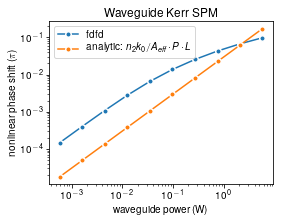

In [20]:
from fdfdpy.constants import *
width = dl*40
height = width
Aeff = width*height # Assume square wg if extrapolated to 3D
# n2 = 2.7e-14*1e-4/simulation.L0**2
n2 = 3*chi3/(3e8/simulation.L0)/np.sqrt(12.25)/(EPSILON_0*simulation.L0)
L = dl*400
gamma_spm = (omega/3e8*simulation.L0)*n2/Aeff

plt.figure(figsize=(4,3))
plt.loglog(pwr_vec*height, -np.unwrap(np.angle(T_vec)-np.angle(T_linear))/np.pi, "-o", label="fdfd")
plt.loglog(pwr_vec*height, (pwr_vec*height)*L*gamma_spm/np.pi, "-o", label=r"analytic: $n_2k_0/A_{eff}\cdot P \cdot L$")
plt.xlabel("waveguide power (W)")
plt.ylabel("nonlinear phase shift ($\pi$)")
plt.title("Waveguide Kerr SPM")
plt.legend()
plt.show()

In [21]:
3*chi3/(3e8/simulation.L0)/np.sqrt(12.25)/(EPSILON_0*simulation.L0)

0.00090352725316369

In [22]:
2.7e-14*1e-4/simulation.L0**2

2.7e-06